## NYC Taxi Dataset Analysis using Time Series

In [2]:
import numpy as np
import pandas as pd
from lstm_functions import WindowGenerator
from fft_utils import FFTFeatureExtractor
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# NYC taxi dataset
train_df = pd.read_csv('../sample-data/train/train.csv')
test_df = pd.read_csv('../sample-data/test/test.csv')

train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.store_and_fwd_flag = train_df.store_and_fwd_flag.apply(lambda x: 1 if x=='Y' else 0)

ts_train = train_df.groupby(pd.Grouper(key='pickup_datetime', freq='T'))[['passenger_count','trip_duration']].sum().reset_index()
ts_train['time_min'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()/60
ts_train['time_sec'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()

date_time = ts_train.pop('pickup_datetime')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60

ts_train['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ts_train['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
ts_train['pass_count_standardized'] = (ts_train['passenger_count'] - np.mean(ts_train['passenger_count'])) / np.std(ts_train['passenger_count'])
ts_train['trip_duration_truncated'] = ts_train.trip_duration.apply(lambda x: min(14000, x))
ts_train['trip_duration_std'] = (ts_train.trip_duration_truncated - np.mean(ts_train.trip_duration_truncated)) / np.std(ts_train.trip_duration_truncated)
ts_train.head()

## FFT Feature Addition

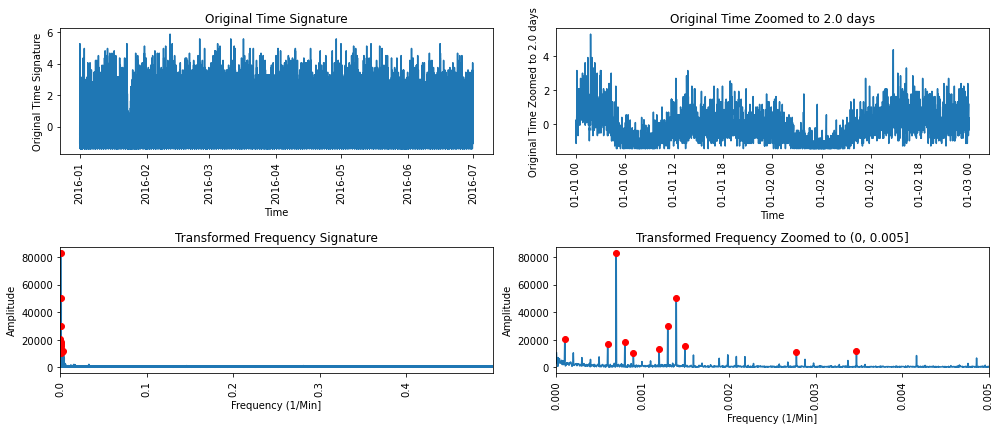

In [4]:
fftExtract = FFTFeatureExtractor(ts_train['pass_count_standardized'], time_series=date_time)
fftExtract.fft_transform(freqlim_max=.005, timelim_max=48*60)

In [5]:
fftExtract.frequency_table_viewer()
filtered_residuals = fftExtract.ifft_transform()

fftExtract.fourier_terms_df_creator()
decomposedResult = fftExtract.decompose_df_into_pure_freq(signal=ts_train['pass_count_standardized'], time_min= ts_train['time_min']  )
decomposedResult['FT_All_Std'] = (decomposedResult['FT_All'] - np.mean(decomposedResult['FT_All'])) / np.std(decomposedResult['FT_All'])
decomposedResult['pass_count_std-FT_All_Std'] = (decomposedResult['pass_count_standardized'] - decomposedResult['FT_All_Std'])

In [6]:
gold_train_table = decomposedResult.merge(ts_train, left_on=['time_min', 'pass_count_standardized'], right_on=['time_min', 'pass_count_standardized'])
gold_train_table.head()

,pass_count_standardized,time_min,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,...,FT_All,FT_All_Std,pass_count_std-FT_All_Std,passenger_count,trip_duration,time_sec,day_sin,day_cos,trip_duration_truncated,trip_duration_std
0,-0.495907,0.0,-19025.269777,20353.750914,25628.566729,18367.142717,11904.160193,7611.043881,-13298.138668,-10193.657445,...,31231.424586,0.400026,-0.895933,6,2143,0.0,-2.008887e-10,1.000000,2143,-0.739953
1,0.263713,1.0,-19378.179612,19950.007706,25497.732054,18372.680000,11972.347514,7554.763719,-13229.152571,-10255.000952,...,30325.801741,0.388426,-0.124713,11,3454,60.0,2.588190e-01,0.965926,3454,-0.359686
2,-1.103604,2.0,-19730.720514,19544.745228,25365.223113,18378.210145,12040.237123,7498.377884,-13159.009961,-10315.770692,...,29418.940430,0.376811,-1.480415,2,1755,120.0,5.000000e-01,0.866025,1755,-0.852496
3,-0.951680,3.0,-20082.885773,19137.994341,25231.048607,18383.733149,12107.827330,7441.887166,-13087.716972,-10375.963266,...,28510.950368,0.365181,-1.316861,3,2417,180.0,7.071068e-01,0.707107,2417,-0.660477
4,-0.192059,4.0,-20434.668681,18729.786022,25095.217345,18389.249010,12175.116457,7385.292354,-13015.279836,-10435.575306,...,27601.941554,0.353538,-0.545597,8,1291,240.0,8.660254e-01,0.500000,1291,-0.987083


In [7]:
train_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][:int(0.7*len(decomposedResult))]
val_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.85*len(decomposedResult)):]

We will try to predict number of passengers here based on these other features, and later introduce categorical features to check on accuracies. 

## Traditional VARMA for Multivariate Forecasting 

In [25]:
OUT_STEPS=10
num_features=5

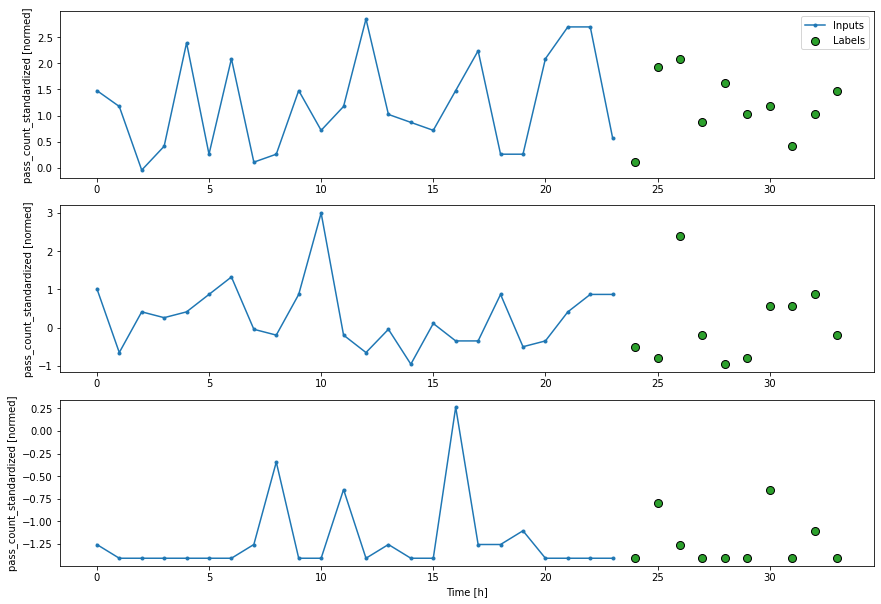

In [30]:
# need to first check on stationarity
multi_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['pass_count_standardized'])
multi_window.plot()

In [31]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Epoch 1/2
5711/5711 [==============================] - 14s 2ms/step - loss: 0.6399 - mean_absolute_error: 0.6108 - val_loss: 0.6090 - val_mean_absolute_error: 0.5997
Epoch 2/2
5711/5711 [==============================] - 12s 2ms/step - loss: 0.6343 - mean_absolute_error: 0.6071 - val_loss: 0.6100 - val_mean_absolute_error: 0.6012


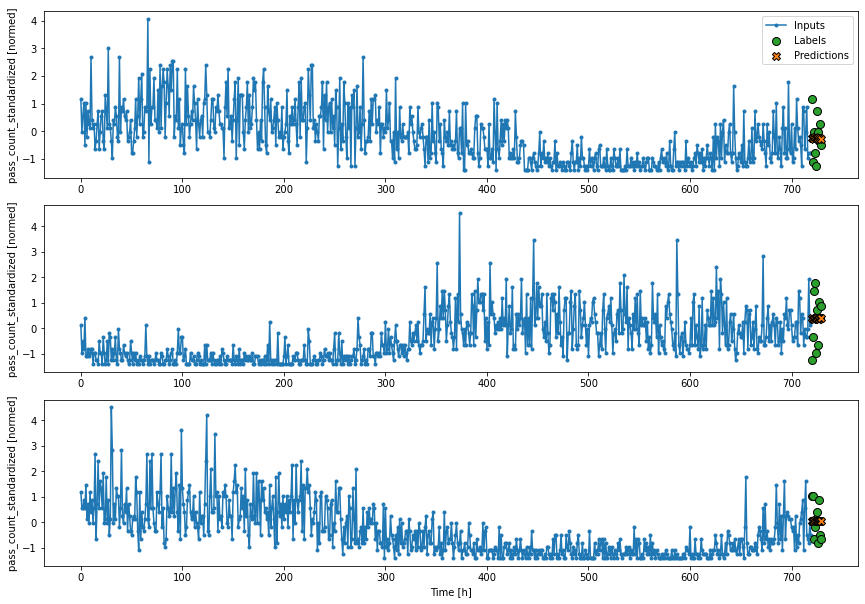

In [28]:
# Dense
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()
# multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
# multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Epoch 1/10
5732/5732 [==============================] - 57s 10ms/step - loss: 0.6106 - mean_absolute_error: 0.5936 - val_loss: 0.5879 - val_mean_absolute_error: 0.5869
Epoch 2/10
5732/5732 [==============================] - 47s 8ms/step - loss: 0.6029 - mean_absolute_error: 0.5887 - val_loss: 0.5863 - val_mean_absolute_error: 0.5856
Epoch 3/10
5732/5732 [==============================] - 49s 9ms/step - loss: 0.6018 - mean_absolute_error: 0.5879 - val_loss: 0.5867 - val_mean_absolute_error: 0.5875
Epoch 4/10
5732/5732 [==============================] - 50s 9ms/step - loss: 0.6012 - mean_absolute_error: 0.5876 - val_loss: 0.5853 - val_mean_absolute_error: 0.5859
Epoch 5/10
5732/5732 [==============================] - 50s 9ms/step - loss: 0.6008 - mean_absolute_error: 0.5874 - val_loss: 0.5855 - val_mean_absolute_error: 0.5867
Epoch 6/10
5732/5732 [==============================] - 46s 8ms/step - loss: 0.6005 - mean_absolute_error: 0.5872 - val_loss: 0.5859 - val_mean_absolute_error: 0.58

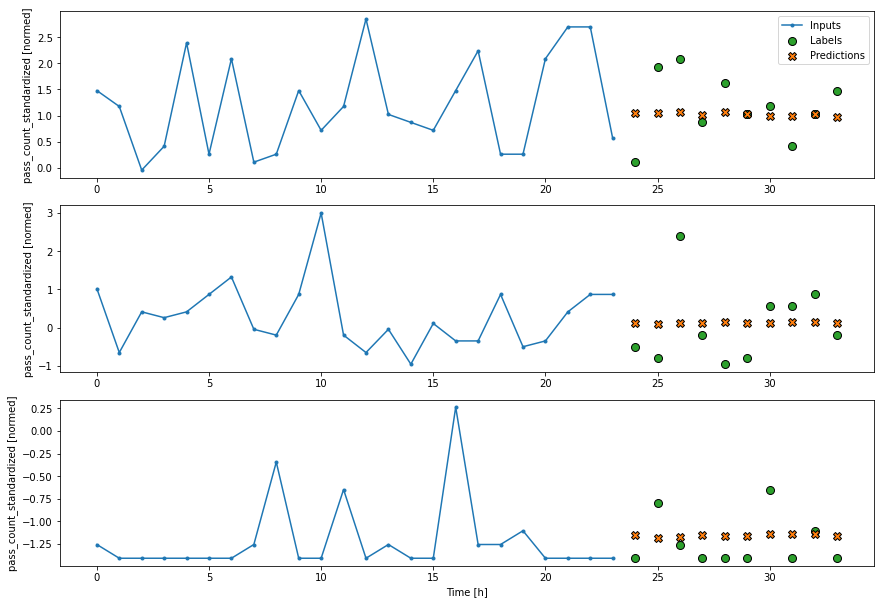

In [32]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)